# Iterative LQR (iLQR)
This algorithm is a special case (the ["gauss-newton"](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) version) of [Differential Dynamic Programming](https://en.wikipedia.org/wiki/Differential_dynamic_programming). It is a trajectory optimization method that uses the recursive structure of the Value iteration problem and local quadratic approximations of the dynamics and cost to efficiently find local solutions for the optimal trajectory in the sense of some user-specified cost.

## To run this notebook:

1. Clone the class demos github repo: `git clone https://github.com/Nonlinear-Control-EMAE-485/EMAE485-demos.git`
2. Ensure you are using a conda environment (or venv if you prefer) with dependencies installed 
3. cd into the repository folder
4. Launch the notebook: `jupyter notebook iLQR_demo.ipnyb`

In [1]:
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import numpy as np
import os
from pathlib import Path
import time
import control


## Mujoco Helper Functions
This cell consists of helper functions to interface with Mujoco

In [2]:
def set_state(model, data, x):
    """
    If x = [qpos; qvel], set data.qpos and data.qvel accordingly.
    Then mj_forward to finalize states (contacts, etc.).
    """
    nq = model.nq
    nv = model.nv
    data.qpos[:] = x[:nq]
    data.qvel[:] = x[nq:nq+nv]
    mujoco.mj_forward(model, data)

def get_state(model, data):
    """
    Return state vector [qpos; qvel] from MuJoCo data.
    """
    nq = model.nq
    nv = model.nv
    return np.concatenate([data.qpos[:nq], data.qvel[:nv]])

def step_mujoco(model, data, x, u, dt=0.01):
    """
    Applies control u at state x, steps the simulation for one discrete step,
    and returns the new state x_next.
    For a purely 'discrete' approach, we do one mj_step or a small number of steps.
    """
    # Set the state
    set_state(model, data, x)
    # Apply control
    data.ctrl[:] = u
    # Step forward once or multiple times to approximate discrete dynamics
    mujoco.mj_step(model, data)  
    # (Optionally do multiple substeps if needed for accuracy)
    
    # Collect next state
    x_next = get_state(model, data)
    return x_next

def discrete_jacobian(model, data, x, u):
    """
    Use MuJoCo's mjd_transitionFD to compute A, B at (x,u).
    This is 1st derivative wrt x, u of the discrete transition function x_{k+1}=f(x_k,u_k).
    By default it uses the dimension 2*nv (position and velocity).
    Adjust if your system dimension is different.
    """
    nq = model.nq
    nv = model.nv

    Nx = 2 * nv
    Nu = model.nu
    
    # Set the state for this linearization point
    set_state(model, data, x)
    data.ctrl[:] = u
    
    # We now call mjd_transitionFD
    A = np.zeros((Nx, Nx))
    B = np.zeros((Nx, Nu))
    eps = 1e-5
    flg_centered = 1
    mujoco.mjd_transitionFD(model, data, eps, flg_centered, A, B, None, None)
    return A, B

def dfdx_mujoco(model, data, x, u):
    A, _ = discrete_jacobian(model, data, x, u)
    return A

def dfdu_mujoco(model, data, x, u):
    _, B = discrete_jacobian(model, data, x, u)
    return B


## Cost Computations
This cell contains our cost computations i.e. $J$ in the notation we have been using, where our stage cost is $\ell_k(x_k,u_k)$ for $k=1:N-1$ and our terminal cost is $\ell_N(x_N)$. The values of $Q$, $R$, and $Q_f$ are your main levers for tuning the algorithm and prescribing the behaviors that you want. It turns out that these simple costs can be incredibly powerful for shaping behavior.

In [3]:
# Acrobot cost weighting
Nx = 4 
Nu = 1

Q = np.diag([1.0, 1.0, 0.05, 0.05])
R = 0.01 * np.eye(Nu)
Qf = 30000*np.eye(4)

def stage_cost(x, u, x_goal):
    return 0.5 * (x - x_goal).T @ Q @ (x - x_goal) + 0.5 * u.T @ R @ u

def terminal_cost(x, x_goal):
    return 0.5 * (x - x_goal).T @ Qf @ (x - x_goal)

def rollout_cost(model, data, x0, U, x_goal, dt=0.01):
    """
    Compute total cost from rolling out a control sequence U from x0.
    U has shape (Nu, horizon), x0 is Nx.
    """
    cost_val = 0.0
    x = x0.copy()
    for k in range(U.shape[1]):
        cost_val += stage_cost(x[:,k], U[:, k], x_goal)
    cost_val += terminal_cost(x[:,-1], x_goal)
    return cost_val


## Backward Pass
In this cell, we create a function to step backward in time from $N$ (or $H$ in this case) to time $k=0$. Our goal is to recursively calculate the control policy described by $d_{ff}$ and $K_{fb}$ that minimizes the cost of our estimated cost with respect to our local dynamics approximation ($A,B$). As discussed in class, this minimization is achieved by going downhill using a 2nd order Taylor expansion, or in optimization terms by a variant of [Newton's method](https://en.wikipedia.org/wiki/Newton's_method). At each step $k$, we minimize the value function with respect to $\Delta u$ using the locally approximate Hessians and gradients of the cost-to-go ($P_{k+1}$ and $p_{k+1}$), solve for $\Delta_u$, calculate our new locally approximate Hessians and gradients of the cost-to-go ($P_{k}$ and $p_{k}$), and recursively move to $k-1$. At each step, because $G_{uu}$ can become very small we regularize it. We also accumulate our change in cost over the loop $\Delta J$

In [4]:
def backward_pass(model, data, X, U, x_goal):
    """
    X: Nx-by-(horizon+1) array of states
    U: Nu-by-horizon array of controls
    x_goal: Nx array
    Returns: feedforward d, feedback K, and cost reduction ΔJ
    """
    Nx, H = X.shape[0], X.shape[1] - 1
    Nu = U.shape[0]
    
    # Value function expansions
    p = np.zeros((Nx, H+1))          # dV/dx
    P = np.zeros((Nx, Nx, H+1))      # d^2V/dx^2
    
    # Terminal condition
    p[:, H] = Qf @ (X[:, H] - x_goal)
    P[:, :, H] = Qf
    
    # Gains for the local policy
    d_ff = np.zeros((Nu, H))  # feedforward term
    K_fb = np.zeros((Nu, Nx, H))  # feedback gains
    
    ΔJ = 0.0
    
    for k in range(H - 1, -1, -1):
        xk = X[:, k]
        uk = U[:, k]
        
        # Compute A, B
        A,B = discrete_jacobian(model, data, xk, uk)
        # Cost gradients
        q = Q @ (xk - x_goal)
        r = R @ uk
        
        gx = q + A.T @ p[:, k+1]        # partial wrt x
        gu = r + B.T @ p[:, k+1]        # partial wrt u
        
        # Cost Hessians
        # This is where we chopped off the tensor terms. These 4 lines are the only difference between DDP and iLQR
        Gxx = Q + A.T @ P[:, :, k+1] @ A 
        Guu = R + B.T @ P[:, :, k+1] @ B
        Gxu = A.T @ P[:, :, k+1] @ B
        Gux = B.T @ P[:, :, k+1] @ A
        
        # Basic regularization (Gauss-Newton style)
        reg = 1e-6
        # Make sure Guu is invertible
        Guu_reg = Guu + reg * np.eye(Nu)
        
        # Solve for policy
        d_ff[:, k] = np.linalg.solve(Guu_reg, gu)
        K_fb[:, :, k] = np.linalg.solve(Guu_reg, Gux)
        
        # Update p, P
        p[:, k] = gx - K_fb[:, :, k].T @ gu + K_fb[:, :, k].T @ Guu @ d_ff[:, k] - Gxu @ d_ff[:, k]
        P[:, :, k] = (Gxx
                      + K_fb[:, :, k].T @ Guu @ K_fb[:, :, k]
                      - Gxu @ K_fb[:, :, k]
                      - K_fb[:, :, k].T @ Gux)
        
        ΔJ += gu.T @ d_ff[:, k]
    
    return d_ff, K_fb, ΔJ


## Forward Pass
The forward pass simply conducts a "rollout" of our dynamics. A rollout is simply a forward simulation until our final time (in this case we call our horizon $H$ but it is also often called $N$). At each time of our rollout, we apply our previously calculated $u_k$ at each step and simply store $x_{k+1}$ in a list. We can then use our trajectory to calculate the cost. To ensure that our algorithm reduces cost, we use a very simple [line search](https://en.wikipedia.org/wiki/Line_search) to aid in finding the local minimum. Essentially, the line search just reduces the percentage of $d_{ff}$ that we are applying each time we fail to reduce the cost. This effectively takes shorter steps in the cost function landscape that we are trying to minimize.

In [5]:
def forward_pass(model, data, X, U, d_ff, K_fb, x_goal, dt=0.01):
    """
    Rolls out a new trajectory using the policy update:
        u_new[k] = u_old[k] - alpha * d_ff[k] - K_fb[k]*(x_new[k] - x_old[k])
    with a line search on alpha.
    Returns (X_new, U_new, cost_new).
    """
    Nx, H = X.shape[0], X.shape[1] - 1
    Nu = U.shape[0]
    # Original cost
    old_cost = rollout_cost(model, data, X, U, x_goal, dt)
    
    # We'll do a backtracking line search
    alpha = 1.0
    backtrack_factor = 0.5
    improvement_condition = 1e-4
    
    while True:
        # Roll out with this alpha
        X_new = np.zeros_like(X)
        U_new = np.zeros_like(U)
        x = X[:, 0].copy()
        X_new[:, 0] = x
        
        for k in range(H):
            # Apply iLQR policy update
            du = alpha * d_ff[:, k] + K_fb[:, :, k] @ (x - X[:, k])
            U_new[:, k] = U[:, k] - du
            
            x_next = step_mujoco(model, data, x, U_new[:, k], dt)
            X_new[:, k+1] = x_next
            x = x_next
        
        new_cost = rollout_cost(model, data, X_new, U_new, x_goal, dt)
        
        # Check improvement
        if np.isnan(new_cost):
            # If the cost is NaN, reduce alpha
            alpha *= backtrack_factor
        else:
            # Condition for improvement
            if new_cost < old_cost - improvement_condition * alpha:
                # Accept
                return X_new, U_new, new_cost
            else:
                alpha *= backtrack_factor
        
        # If alpha is too small, just accept it
        if alpha < 1e-6:
            return X_new, U_new, new_cost


## iLQR Algorithm
This puts it all together. We initialize the inputs (**initial inputs are SUPER important!!!!!**), perform an initial rollout, calculate cost, perform a backward pass based on that cost to calculate a new control policy, perform a forward pass to get a new trajectory and cost, check for convergence, and then go back to another backwards pass and proceed in a loop from there. 

The last major control lever that you, the designer, have to play around with is initial conditions. It is hard to overstate how important these are. You can end up producing wildly different behaviors with different initializations. While this can be considered a bad thing, I would also argue that this expressive capability actually underscores the power of this class of algorithms to capture a wide range of behavior.

Note that this implementation is extremely slow for iLQR. Python is a terrible choice of programming language for any algorithm that involves many loops. The purpose of this implementation is maximum clarity. For real problems, we have other options.

In [6]:
def iLQR_mujoco(model, data, x0, x_goal, H=50, max_iters=100, dt=0.01):
    """
    End-to-end iLQR with MuJoCo.
    - H: horizon
    - x0: initial state (dimension Nx, presumably = 2*nv or nq+nv)
    - x_goal: goal state
    """
    Nx = len(x0)
    Nu = model.nu

    # Initialize controls randomly (or zeros)
    # You can play around with initialization to get different results
    U = -np.random.normal(0.0, 1.0, (Nu, H))*10
    
    # Roll out initial trajectory
    X = np.zeros((Nx, H+1))
    x = x0.copy()
    for k in range(H):
        X[:, k] = x
        x = step_mujoco(model, data, x, U[:,k], dt)
    X[:, H] = x

    old_cost = rollout_cost(model, data, X, U, x_goal, dt)
    try:
        for iteration in range(max_iters):
            # 1) Backward pass
            d_ff, K_fb, dJ = backward_pass(model, data, X, U, x_goal)
            # 2) Forward pass + line search
            X_new, U_new, new_cost = forward_pass(model, data, X, U, d_ff, K_fb, x_goal, dt)
            
            # Check improvement
            if np.abs(new_cost - old_cost) < 1e-8 and np.max(np.abs(d_ff)) < 1e-1:
                print(f'Converged at iteration={iteration}, cost={new_cost}')
                # print(old_cost)
                return X_new, U_new, K_fb
            
            # Accept new trajectory
            X, U, old_cost = X_new, U_new, new_cost
            print(f'iter={iteration}, cost={new_cost}, dff={np.max(np.abs(d_ff))}')
        return X, U, K_fb
    except KeyboardInterrupt:
        return X, U, K_fb


## Run Simulation

In [7]:
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
os.environ["MUJOCO_GL"] = "egl"

model_name = f"double_pendulum"

model_path = Path("mujoco_models") / (str(model_name) + str(".xml"))
# Load the model and data
model = mujoco.MjModel.from_xml_path(str(model_path.absolute()))
model.dof_damping[:] = 0.001
data = mujoco.MjData(model)

x0 = np.array([np.pi, 0.0, 0.0, 0.0])
x_goal = np.zeros(model.nq + model.nv)

# 3) Run iLQR
dt = 0.005
model.opt.timestep = dt
H = 1300
X_opt, U_opt, K_fb = iLQR_mujoco(model, data, x0, x_goal, H=H, max_iters=1000, dt=dt)


iter=0, cost=1568505.884647893, dff=1917.210754107201
iter=1, cost=690172.1616615029, dff=1942.589614214752
iter=2, cost=666852.2403494515, dff=1168.0766184685021
iter=3, cost=635365.3646679299, dff=897.7280844415849
iter=4, cost=591837.5535701143, dff=826.487470313912
iter=5, cost=550849.5825633665, dff=850.642965691907
iter=6, cost=218932.49234117777, dff=853.5260139881236
iter=7, cost=167974.69094500237, dff=651.2355245159134
iter=8, cost=164476.49610107666, dff=505.9111643227203
iter=9, cost=131747.09952426006, dff=371.66282653755866
iter=10, cost=93328.5474016679, dff=277.79819197183065
iter=11, cost=75442.64885371292, dff=211.5774268727862
iter=12, cost=60852.40756265574, dff=185.52601624681867
iter=13, cost=54731.52238539297, dff=162.69437626987425
iter=14, cost=49285.495725102955, dff=152.51539911245357
iter=15, cost=44454.3604340477, dff=142.97247577024203
iter=16, cost=40177.0026617288, dff=134.01932416019056
iter=17, cost=36391.45588911241, dff=125.61447427364328
iter=18, co

## Forward Simulation and Visualization

In [8]:
def simulate_with_viewer(model, data, X, U, dt=0.01, substeps=1):
    """
    Forward-simulate the system in a MuJoCo viewer using the provided trajectory (X, U).
    - model, data: MuJoCo model and data
    - X: Nx x (H+1) array of states [qpos; qvel; ...]
    - U: Nu x H array of controls
    - dt: time step for each control
    - substeps: how many mj_step calls to simulate each dt

    This function sets the state to X[:,k], applies U[:,k] as control,
    and steps the simulation for 'substeps' times, rendering at each step.
    """
    # Number of time steps
    horizon = U.shape[1]  # The number of controls
    data.qpos = [np.pi, 0]
    data.qvel = [0, 0]
    with mujoco.viewer.launch_passive(model, data) as viewer:
        for k in range(horizon):
        
            # Place the simulation at X[:, k]
            # set_state(model, data, X[:, k])
    
            # Apply control
            data.ctrl[:] = U[:, k]
    
            # Step the simulation substeps times
            for _ in range(substeps):
                mujoco.mj_step(model, data)
                viewer.sync()
                # Sleep so that the simulation doesn't fly by too quickly
                time.sleep(dt / substeps/2)
    
        # Final state: place the simulator at X[:, horizon]
        set_state(model, data, X[:, horizon])
        
        # Keep the final state visible for a moment
        time.sleep(1.0)
    
    # # Close the viewer
        viewer.close()


In [9]:
simulate_with_viewer(model, data, X_opt, U_opt, dt=dt, substeps=1)

2025-02-27 16:32:22.601 mjpython[51110:12642485] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-27 16:32:22.601 mjpython[51110:12642485] +[IMKInputSession subclass]: chose IMKInputSession_Modern


## Plotting

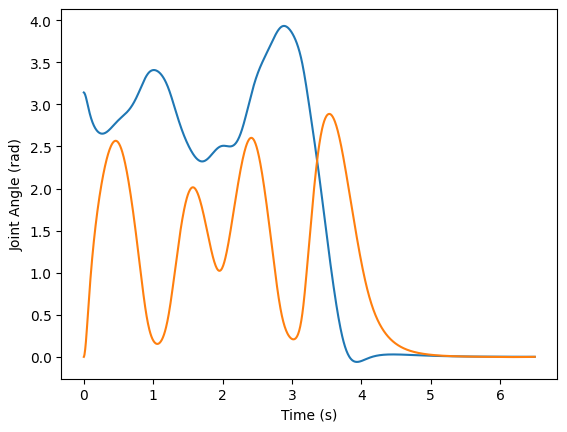

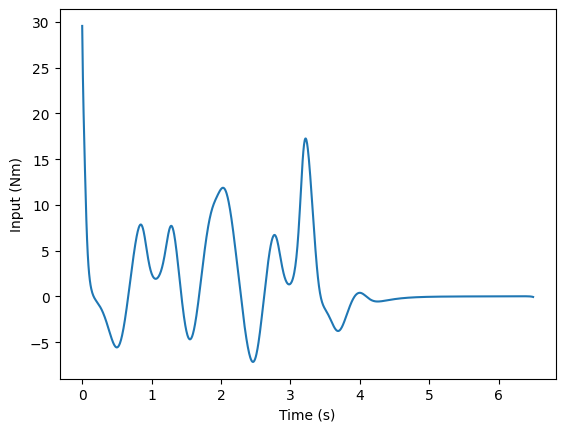

In [10]:
import matplotlib.pyplot as plt
plt.figure()
H = 1300
times = np.arange(0, (H + 1) * dt, dt)
plt.plot(times, X_opt[0, :], label='State 1')
plt.plot(times, X_opt[1, :], label='State 2')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.show()

plt.figure()
plt.plot(times[:-1], U_opt.T, label='Input 1')
plt.xlabel('Time (s)')
plt.ylabel('Input (Nm)')
plt.show()
